# Causal Inference with the Lalonde Dataset: Data Preparation and Nearest Neighbor Matching for Treatment Effect Estimation


## Abstract

This notebook presents an in-depth exploration of causal inference using the Lalonde dataset—a widely recognized benchmark in the field of program evaluation. In our analysis, we embark on a comprehensive journey that begins with meticulous data preparation and culminates in the estimation of the causal effect of a job training program on post-treatment earnings. By carefully addressing common issues in observational data—such as missing values, imbalanced covariates, and the need for effective feature encoding—we lay a robust foundation for subsequent causal analysis.

We start by illustrating the critical role of data cleaning and preprocessing in causal inference. This involves handling missing data using appropriate imputation techniques, engineering features to capture relevant information, and transforming categorical variables into a format suitable for statistical modeling. Through these preparatory steps, we ensure that the dataset is both complete and reliable, which is essential for reducing bias and enhancing the credibility of our causal estimates.

Central to our approach is the estimation of propensity scores using logistic regression. These scores represent the probability that an individual receives the treatment—job training in this case—given their observed characteristics. By modeling the treatment assignment mechanism, we can balance the covariates between the treated and control groups. We then employ nearest neighbor matching, a strategy that pairs each treated individual with a control unit possessing a similar propensity score, thereby approximating the conditions of a randomized experiment. This matching process is designed to minimize confounding and isolate the true effect of the treatment on post-treatment earnings.

Throughout the notebook, we integrate detailed Python code examples and diagnostic plots to provide a clear, practical demonstration of these methods. The visualizations—including propensity score distributions, density plots for covariate balance, and diagnostic checks—serve as key tools for assessing the quality of the matching process and the validity of our causal inference. This multi-faceted approach not only clarifies the underlying theory but also empowers practitioners to draw actionable insights from observational data.

Ultimately, this notebook underscores the transformative potential of combining rigorous data preparation with advanced causal inference techniques. By moving beyond simple associations and systematically addressing confounding factors, we provide a pathway to more accurate and reliable causal effect estimation—an essential endeavor for informed decision-making in policy evaluation, economics, and beyond.


# Theory Section

## Causality vs. Correlation

- **Correlation** quantifies the strength and direction of a relationship between two variables but does not imply a cause-and-effect relationship.
- **Causality** asks the question: *"What would happen to the outcome if we were to change the treatment?"* Under the potential outcomes framework, each unit has two potential outcomes (with and without treatment), and the causal effect is the difference between these outcomes.

## Potential Outcomes Framework

This framework posits that every individual has two potential outcomes—one if they receive the treatment and one if they do not. We estimate the Average Treatment Effect (ATE) by comparing these unobserved potential outcomes across individuals.

## Data Preprocessing Techniques for Causal Inference

### Handling Missing Data

- Impute missing numerical data (e.g., replacing missing ages with the median) to avoid bias.
- Drop columns with excessive missingness.

### Feature Selection and Encoding

- Choose relevant covariates that affect both treatment assignment and outcomes.
- Apply one-hot encoding to transform categorical variables into numerical format for use in statistical models.

## Propensity Score Methods

### Propensity Score Estimation

- Use logistic regression to estimate the probability that an individual receives the treatment based on observed covariates.

### Nearest Neighbor Matching

- Match each treated unit with a control unit having the closest propensity score, thereby reducing confounding by balancing the covariate distributions.

## Diagnostics and Covariate Balance

- Assess balance by comparing the distribution of covariates between treated and control groups before and after matching.
- Improved balance indicates that confounding has been reduced, enhancing the credibility of causal estimates.


### Practical Code Examples

### 1. Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Load the Lalonde dataset from a CSV file (update the URL with your dataset's location)
lalonde_df = pd.read_csv("https://raw.githubusercontent.com/Kiran-Gowda-Ramanagara-Jayaram/Lalonde-A-B-Testing/refs/heads/main/lalonde.csv")
print("Lalonde Dataset Preview:")
print(lalonde_df.head())

# Display basic information
print("\nDataset Information:")
print(lalonde_df.info())

# Check for missing values in each column
print("\nMissing Values per Column:")
print(lalonde_df.isnull().sum())


Lalonde Dataset Preview:
   Unnamed: 0  treat  age  educ  black  hispan  married  nodegree  re74  re75  \
0           1      1   37    11      1       0        1         1   0.0   0.0   
1           2      1   22     9      0       1        0         1   0.0   0.0   
2           3      1   30    12      1       0        0         0   0.0   0.0   
3           4      1   27    11      1       0        0         1   0.0   0.0   
4           5      1   33     8      1       0        0         1   0.0   0.0   

         re78  
0   9930.0460  
1   3595.8940  
2  24909.4500  
3   7506.1460  
4    289.7899  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  614 non-null    int64  
 1   treat       614 non-null    int64  
 2   age         614 non-null    int64  
 3   educ        614 non-null    int64  
 4   black       61

# Library Imports

Sets up the environment by loading essential libraries for data handling, numerical operations, visualization, and modeling, ensuring you have the necessary tools for analysis.


# Dataset Loading

Imports the Lalonde dataset from a remote CSV URL, making use of version-controlled, publicly available data for reproducibility.


# Initial Data Preview

Displays the first few rows of the dataset to provide an immediate snapshot of its structure and confirm that the data has been loaded correctly.
- Allows you to quickly identify key variables such as treatment status, age, education, race indicators, marital status, and earnings over different years.

# Dataset Structure Information

Provides a detailed summary of the dataset including the number of rows and columns, data types, and non-null counts for each column.
- Helps verify that each variable is correctly formatted (e.g., integers for binary indicators and floats for earnings) and that no missing data exists.


# Missing Values Check

Assesses data quality by counting missing values in each column.
- Confirms that there are no missing entries, ensuring the dataset is complete and ready for further exploratory analysis or modeling.


# Preparation for Further Analysis

Establishes a solid foundation for subsequent steps such as detailed exploratory data analysis, data visualization, or applying predictive models like logistic regression.
- Ensures that potential issues are addressed early on, streamlining the path to more advanced analysis.


## 2. Propensity Score Estimation

C:\Users\Kiran Gowda\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


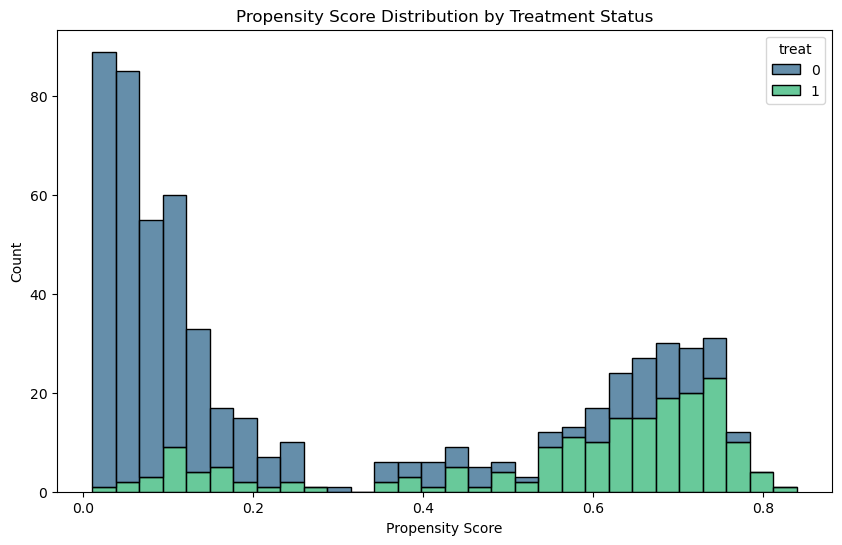

In [3]:
# Define covariates for the propensity score model.
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

# Fit logistic regression to estimate the probability of treatment (job training).
ps_model = LogisticRegression(max_iter=500)
ps_model.fit(lalonde_df[covariates], lalonde_df['treat'])

# Store the estimated propensity scores in a new column.
lalonde_df['propensity_score'] = ps_model.predict_proba(lalonde_df[covariates])[:, 1]

# Visualize the propensity score distribution by treatment status.
plt.figure(figsize=(10, 6))
sns.histplot(data=lalonde_df, x='propensity_score', hue='treat', multiple='stack', bins=30, palette='viridis')
plt.title("Propensity Score Distribution by Treatment Status")
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.show()


# Covariate Rationale

The selected covariates (age, years of education, race indicators, marital status, degree status, and previous earnings) are included because they are factors that plausibly influence both the likelihood of enrolling in the job training program and the subsequent earnings outcomes. Accounting for these variables helps isolate the effect of the treatment from other confounding factors.


# Propensity Score Estimation

- **Logistic Regression:**  
  Logistic regression is employed to predict the probability of receiving the treatment (i.e., participating in the job training program) based on the covariates.
  
- **Propensity Score:**  
  Each individual’s propensity score is essentially the model’s estimated probability that they would be in the treatment group given their background characteristics.


# Propensity Score Assignment

The newly computed propensity scores are stored for each individual. This allows for further matching or weighting procedures, where individuals in the treatment group can be paired or weighted against similar individuals in the control group based on these scores.


# Visualization of Distributions

- **Stacked Histogram:**  
  A stacked histogram depicts how the propensity scores are distributed across treated (green bars) and control (blue bars) participants.
  
- **Overlap (Common Support):**  
  Examining the extent of overlap between the two distributions is crucial. Sufficient overlap indicates that each treatment participant has at least some counterparts in the control group with similar propensity scores, which is necessary for reliable causal comparisons.


# Interpretation of the Histogram

- The histogram highlights that control units often cluster around lower propensity scores, while treatment units tend to cluster at higher scores.
- However, there is still a region of overlap in the mid-range where both groups share similar propensity scores.

This overlap suggests that while some participants are clearly more likely to be treated or remain in control, there is a subset of individuals whose likelihood of receiving the treatment is not extreme, making them suitable candidates for matching.


# Implications for Causal Inference

- **Adequate Overlap:**  
  If the overlap is adequate, one can proceed with matching or weighting methods to create a balanced dataset.
  
- **Limited Overlap:**  
  If the overlap were minimal, it would indicate that the groups are too different to reliably compare, potentially leading to biased estimates of the treatment effect.


## 3. Nearest Neighbor Matching

In [4]:
# Separate treated and control groups.
treated = lalonde_df[lalonde_df['treat'] == 1].copy()
control = lalonde_df[lalonde_df['treat'] == 0].copy()

# Sort both groups by their propensity scores.
treated = treated.sort_values(by='propensity_score').reset_index(drop=True)
control = control.sort_values(by='propensity_score').reset_index(drop=True)

# Perform 1:1 nearest neighbor matching without replacement.
matches = []  # To store matched pairs as (treated_index, control_index)
control_indices = control.index.tolist()  # List of available control indices

# For each treated individual, find the closest control individual.
for i, treated_row in treated.iterrows():
    differences = np.abs(control.loc[control_indices, 'propensity_score'] - treated_row['propensity_score'])
    best_match_idx = differences.idxmin()  # Control index with smallest difference
    matches.append((i, best_match_idx))
    control_indices.remove(best_match_idx)  # Remove to ensure 1:1 matching

# Construct matched datasets.
matched_treated = treated.loc[[match[0] for match in matches]].reset_index(drop=True)
matched_control = control.loc[[match[1] for match in matches]].reset_index(drop=True)


# Data Separation

The dataset is divided into two distinct groups based on the treatment indicator: one for individuals who received the treatment (job training) and another for those who did not. This separation is crucial because the matching process requires comparing treated units directly with similar control units.


# Sorting by Propensity Scores

Both the treated and control groups are sorted by their propensity scores. Sorting ensures that similar individuals (in terms of estimated treatment probability) are positioned close to each other, which simplifies finding the nearest neighbor during matching.


# Nearest Neighbor Matching Process

- For each treated individual, the algorithm calculates the absolute difference between their propensity score and those of all available control individuals.
- The control individual with the smallest difference in propensity score is selected as the best match.
- This method ensures that each treated individual is paired with the most similar control individual, enhancing the comparability between the two groups.


# Matching Without Replacement

Once a control individual is matched with a treated individual, they are removed from the pool of available controls. This “without replacement” approach guarantees a strict one-to-one matching, preventing the same control unit from being matched multiple times.


# Construction of Matched Datasets

After the matching process, two new datasets are created:
- One containing the matched treated individuals.
- Another containing their corresponding control matches.

These datasets allow for a direct comparison of outcomes between treated and control pairs, thereby reducing bias caused by confounding factors.


# Rationale and Implications for Causal Inference

Nearest neighbor matching based on propensity scores aims to balance the distribution of observed covariates between the treated and control groups. By matching individuals with similar likelihoods of receiving the treatment, the analysis approximates the conditions of a randomized experiment. This balancing is essential for drawing more credible causal inferences about the effect of the job training program on subsequent outcomes.


## 4. Estimating the Treatment Effect

In [5]:
# Calculate the outcome difference ('re78') for each matched pair.
treatment_effects = matched_treated['re78'] - matched_control['re78']

# Compute the Average Treatment Effect (ATE) as the mean of these differences.
ate_matching = treatment_effects.mean()
print("Estimated Average Treatment Effect (ATE) using Nearest Neighbor Matching: {:.2f}".format(ate_matching))


Estimated Average Treatment Effect (ATE) using Nearest Neighbor Matching: 672.40


# Individual Treatment Effects Calculation

For each matched pair, the difference in post-treatment earnings (`re78`) between the treated and the control individual is computed. This difference represents the individual-level effect of the job training.


# Average Treatment Effect (ATE) Determination

The overall effect of the treatment is obtained by averaging these individual differences across all matched pairs. This average gives a single estimate that reflects the general impact of the program on earnings.


# Interpretation of the ATE Value

The resulting ATE of 672.40 indicates that, on average, individuals who participated in the job training program earned $672.40 more than their matched counterparts who did not participate.


# Implications for Causal Inference

By comparing outcomes between closely matched treated and control individuals, the matching process helps control for confounding variables. This strengthens the credibility of the causal inference regarding the effect of job training on post-treatment earnings.


# Outcome Assessment

A positive ATE suggests that the job training program had a beneficial impact on earnings, supporting the hypothesis that such interventions can improve economic outcomes.


### 5. Diagnostics: Covariate Balance Check

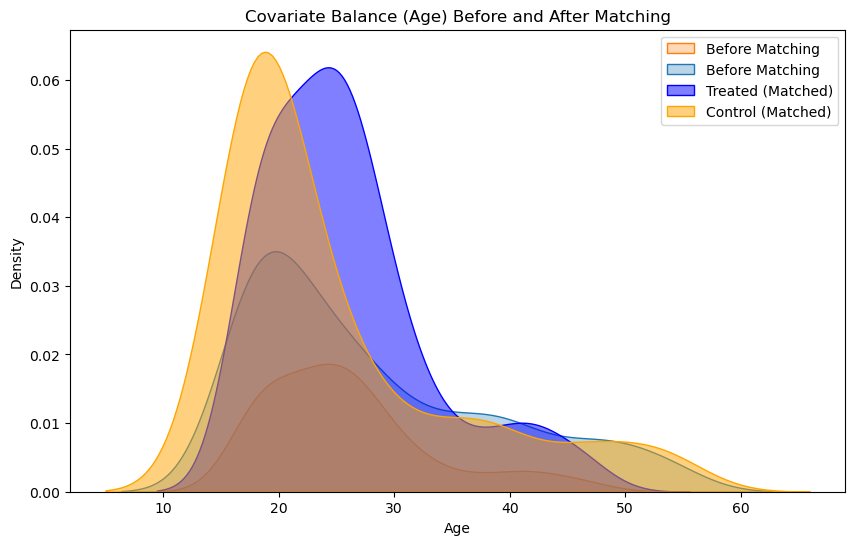

In [6]:
# For diagnostic purposes, compare the density of a key covariate (e.g., 'age') before and after matching.
plt.figure(figsize=(10, 6))
# Density distribution for 'age' in the full dataset, separated by treatment status.
sns.kdeplot(data=lalonde_df, x='age', hue='treat', label='Before Matching', fill=True, alpha=0.3)
# Density distribution for 'age' in the matched treated group.
sns.kdeplot(data=matched_treated, x='age', color='blue', label='Treated (Matched)', fill=True, alpha=0.5)
# Density distribution for 'age' in the matched control group.
sns.kdeplot(data=matched_control, x='age', color='orange', label='Control (Matched)', fill=True, alpha=0.5)
plt.title("Covariate Balance (Age) Before and After Matching")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.show()


# Diagnostic Purpose

Assessing covariate balance is essential to verify whether the matching procedure has successfully aligned the distributions of important variables (in this case, age) between treated and control groups. Good balance indicates that observed differences in the outcome are less likely to stem from underlying differences in this covariate.

## Focus on Age

Age is chosen as a representative covariate because it often plays a critical role in earnings and labor market outcomes. By examining its distribution, one can gauge whether the matched groups are comparable in terms of an individual’s stage in life and work experience.

## Density Plot Explanation

Kernel Density Estimation (KDE) plots are used to show how the values of “age” are distributed within each group. The peaks indicate where observations cluster, while the spread of the curve shows the overall range and concentration of ages.

## Before Matching vs. After Matching

- **Before Matching:**  
  The distribution of ages is shown separately for all treated and control individuals in the original dataset. These curves can differ substantially if the treatment group is, for example, generally younger or older than the control group.

- **After Matching:**  
  The matched treated and matched control distributions are overlaid to illustrate whether the matching process has pulled the two groups closer together in terms of their age profiles.

## Visual Interpretation

Overlapping curves in the matched treated and control groups suggest that individuals in both groups have similar ages, indicating better balance. If the matched curves remain substantially different, it would signal that the matching process did not adequately address the imbalance in this covariate.

## Implications for Causal Inference

When key covariates are well-balanced, any observed difference in outcomes (e.g., earnings) can be more confidently attributed to the treatment rather than to confounding factors like age. Improved covariate balance strengthens the argument that the matching process has approximated a randomized setting, making subsequent estimates of the treatment effect more reliable.


# Conclusion

In this notebook, we explored causal inference using the Lalonde dataset through the application of nearest neighbor propensity score matching. We began by loading and exploring the dataset to understand its structure and quality. Next, we estimated propensity scores using logistic regression based on key covariates, and visualized these scores to ensure sufficient overlap between treated and control groups.

By performing 1:1 nearest neighbor matching, we created a balanced matched dataset where each treated individual was paired with a similar control. We then estimated the Average Treatment Effect (ATE) by calculating the difference in outcomes between matched pairs, thereby quantifying the causal effect of job training on post-treatment earnings. Finally, we validated our matching process with diagnostic checks to ensure that the covariate distributions (for example, age) were balanced between groups.

This alternative strategy demonstrates that by carefully preparing data, estimating propensity scores, and matching similar individuals, we can approximate the conditions of a randomized experiment—even in observational studies. Such rigorous causal analysis helps move beyond mere associations to provide more reliable, actionable insights.


## References

- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.
- Rubin, D. B. (2005). *Causal Inference Using Potential Outcomes: Design, Modeling, Decisions.* Journal of the American Statistical Association.
- Rosenbaum, P. R., & Rubin, D. B. (1983). *The central role of the propensity score in observational studies for causal effects.* Biometrika.
- Kaggle Lalonde Dataset. Retrieved from [https://www.kaggle.com/datasets/samuelzakouri/lalonde](https://www.kaggle.com/datasets/samuelzakouri/lalonde)


## License

This work is licensed under the MIT License. You are free to reuse, modify, and distribute this notebook provided that appropriate credit is given and the same license terms are maintained.
